In [10]:
# 自动重载模块
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys

# 添加 TPLC_Net 路径
tplc_path = Path('..') / '..' / 'TPLC_Net'
if str(tplc_path.resolve()) not in sys.path:
    sys.path.insert(0, str(tplc_path.resolve()))

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# 中文支持
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

from tplc_algo.pipeline import prepare_greenhouse_datasets, make_loaders
from tplc_algo.train import Trainer, TrainConfig
from tplc_algo.utils import seed_everything
from tplc_algo.exp_utils import (
    create_run_dir,
    save_config_json,
    save_env_json,
    save_history_csv,
    save_metrics_json,
    save_figure,
)

# 导入 TimeMixer
from timemixer import TimeMixerForecaster, TimeMixerConfig

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. 配置

In [11]:
seed_everything(42)

# 数据配置
dataset_root = (Path('..') / '..' / 'datasets' / '自主温室挑战赛').resolve()
team = 'AICU'
seq_len = 288   # 约 1 天
pred_len = 72   # 约 6 小时
stride = 1
batch_size = 32

# 模型配置
d_model = 64
d_ff = 128
e_layers = 2
down_sampling_layers = 2
down_sampling_window = 2
down_sampling_method = 'avg'
decomp_method = 'moving_avg'
moving_avg = 25
top_k = 5
channel_independence = True
dropout = 0.1

# 训练配置
epochs = 20
lr = 1e-3
weight_decay = 0.0
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 稳定性配置
use_amp = (device == 'cuda')
grad_clip_max_norm = 1.0
lr_scheduler = 'plateau'
plateau_patience = 3
plateau_factor = 0.5
early_stop_patience = 6

# 结果目录
exp_name = f"timemixer_greenhouse_{team}"
run_dir = create_run_dir(exp_name, base_dir=Path('results'))
ckpt_path = run_dir / 'checkpoints' / 'timemixer_best.pt'

print('device:', device)
print('dataset_root:', dataset_root)
print('run_dir:', run_dir)

device: cuda
dataset_root: D:\degree_code\scheme_1\datasets\自主温室挑战赛
run_dir: results\timemixer_greenhouse_AICU_20251222_164041


## 2. 数据准备

In [ ]:
# 推荐的10个最重要特征（对温室植物生长影响最大）：
# 1. Tair - 空气温度（最关键）
# 2. Rhair - 空气相对湿度（水分管理）
# 3. CO2air - CO2浓度（光合作用）
# 4. Tot_PAR - 光合有效辐射（光照）
# 5. PipeGrow - 生长管加热（温度控制）
# 6. VentLee - 背风侧通风（通风管理）
# 7. Ventwind - 迎风侧通风（通风管理）
# 8. HumDef - 湿度缺失（蒸腾作用指标）
# 9. water_sup - 灌溉供水量（水分供应）
# 10. EnScr - 节能幕（能量管理）
selected_features = ['Tair', 'Rhair', 'CO2air', 'Tot_PAR', 'PipeGrow', 
                    'VentLee', 'Ventwind', 'HumDef', 'water_sup', 'EnScr']

prepared = prepare_greenhouse_datasets(
    dataset_root=dataset_root,
    team=team,
    seq_len=seq_len,
    pred_len=pred_len,
    stride=stride,
    selected_features=selected_features,  # 直接传入选定特征
    missing_rate_threshold=0.7,
    drop_constant=True,
    protect_target_cols=True,
)

feature_cols = prepared.feature_cols
target_cols = prepared.target_cols
target_scaler = prepared.target_scaler

train_loader, val_loader, test_loader = make_loaders(prepared, batch_size=batch_size)

print('input_dim:', len(feature_cols))
print('target_dim:', len(target_cols), target_cols)
print('train batches:', len(train_loader))
print('val batches:', len(val_loader))
print('test batches:', len(test_loader))

D:\degree_code\scheme_1\TPLC_Net\tplc_algo\data\greenhouse_dataset.py:32: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


input_dim: 101
target_dim: 3 ['Tair', 'Rhair', 'CO2air']
train batches: 1034
val batches: 139
test batches: 288


## 3. 构建模型

In [13]:
config = TimeMixerConfig(
    seq_len=seq_len,
    pred_len=pred_len,
    enc_in=len(feature_cols),
    c_out=len(target_cols),
    d_model=d_model,
    d_ff=d_ff,
    e_layers=e_layers,
    dropout=dropout,
    down_sampling_layers=down_sampling_layers,
    down_sampling_window=down_sampling_window,
    down_sampling_method=down_sampling_method,
    decomp_method=decomp_method,
    moving_avg=moving_avg,
    top_k=top_k,
    channel_independence=channel_independence,
)

model = TimeMixerForecaster(config)

print(f'模型参数量: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M')

模型参数量: 0.55M


## 3.5 模型测试（验证模型是否正常工作）

In [14]:
# 测试模型前向传播
print("测试模型...")
model = model.to(device)  # 将模型移到 GPU/CPU
model.eval()
try:
    with torch.no_grad():
        x_test, y_test = next(iter(train_loader))
        x_test = x_test.to(device)
        y_pred = model(x_test)
    
    print(f"✓ 前向传播成功")
    print(f"  输入形状: {x_test.shape}")
    print(f"  输出形状: {y_pred.shape}")
    print(f"  期望形状: {y_test.shape}")
    
    # 测试梯度
    model.train()
    x_test = x_test[:2].to(device)  # 用小批量测试
    y_test_small = y_test[:2].to(device)
    y_pred = model(x_test)
    loss = torch.nn.functional.mse_loss(y_pred, y_test_small)
    loss.backward()
    print(f"✓ 梯度计算成功，损失: {loss.item():.6f}")
    print("模型可以正常使用！")
except Exception as e:
    print(f"✗ 模型测试失败: {e}")
    import traceback
    traceback.print_exc()
    raise

测试模型...
✓ 前向传播成功
  输入形状: torch.Size([32, 288, 101])
  输出形状: torch.Size([32, 72, 3])
  期望形状: torch.Size([32, 72, 3])
✓ 梯度计算成功，损失: 0.813271
模型可以正常使用！


## 4. 训练

In [15]:
trainer = Trainer(
    model=model,
    cfg=TrainConfig(
        epochs=epochs,
        lr=lr,
        weight_decay=weight_decay,
        device=device,
        ckpt_path=ckpt_path,
        use_amp=use_amp,
        grad_clip_max_norm=grad_clip_max_norm,
        lr_scheduler=lr_scheduler,
        plateau_patience=plateau_patience,
        plateau_factor=plateau_factor,
        early_stop_patience=early_stop_patience,
        show_progress=True,
        progress_granularity='batch',
    )
)

history = trainer.fit(train_loader, val_loader=val_loader)

# 保存配置和训练历史
config_payload = {
    'team': team,
    'dataset_root': str(dataset_root),
    'seq_len': seq_len,
    'pred_len': pred_len,
    'feature_cols': feature_cols,
    'target_cols': target_cols,
    'model': {
        'd_model': d_model,
        'd_ff': d_ff,
        'e_layers': e_layers,
        'down_sampling_layers': down_sampling_layers,
        'down_sampling_window': down_sampling_window,
        'channel_independence': channel_independence,
    },
    'train': {
        'batch_size': batch_size,
        'epochs': epochs,
        'lr': lr,
        'device': device,
    },
}

save_config_json(run_dir, config_payload)
save_env_json(run_dir)
save_history_csv(run_dir, history)

print('训练完成！')
history

train (epoch):  35%|###5      | 7/20 [48:42<1:30:27, 417.47s/epoch, train=0.0548, val=0.5945, stop=best@2]

训练完成！


{'train_loss': [0.22573497358932948,
  0.12923633434036944,
  0.09844675469905773,
  0.0822655353803238,
  0.07347094974114886,
  0.06761861333490225,
  0.05709107713755833,
  0.054822162245859604],
 'val_loss': [0.5633315602408036,
  0.5588129126116906,
  0.5973994011551081,
  0.579667321294445,
  0.5956044839507609,
  0.604256838863453,
  0.6149521772474812,
  0.5944782493071867],
 'val_mae': [0.5702928698486237,
  0.5503258470549516,
  0.5750535743939232,
  0.5613183156313116,
  0.5667077954930165,
  0.5685435638954078,
  0.5677043796664205,
  0.5589714246862912],
 'val_rmse': [0.7082952991434687,
  0.6999935890532974,
  0.7220422793529444,
  0.7141929959932676,
  0.7229655096229454,
  0.727601481438546,
  0.7309270948609786,
  0.7187787096065192]}

## 5. 测试集评估

In [16]:
test_metrics = trainer.evaluate(test_loader)

# 反标准化后的指标
model.eval()
y_true_list = []
y_pred_list = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y_hat = model(x).cpu().numpy()
        y_true_list.append(y.numpy())
        y_pred_list.append(y_hat)

y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

y_true_raw = target_scaler.inverse_transform(
    y_true.reshape(-1, len(target_cols))
).reshape(y_true.shape)
y_pred_raw = target_scaler.inverse_transform(
    y_pred.reshape(-1, len(target_cols))
).reshape(y_pred.shape)

test_metrics['mae_raw'] = float(np.mean(np.abs(y_true_raw - y_pred_raw)))
test_metrics['rmse_raw'] = float(np.sqrt(np.mean((y_true_raw - y_pred_raw) ** 2)))

print('测试集指标:')
for k, v in test_metrics.items():
    print(f'  {k}: {v:.6f}')

save_metrics_json(run_dir, test_metrics)

测试集指标:
  loss: 2.385700
  mae: 1.103666
  rmse: 1.412012
  mae_raw: 124.206451
  rmse_raw: 245.461411


WindowsPath('results/timemixer_greenhouse_AICU_20251222_164041/artifacts/metrics.json')

## 6. 训练曲线

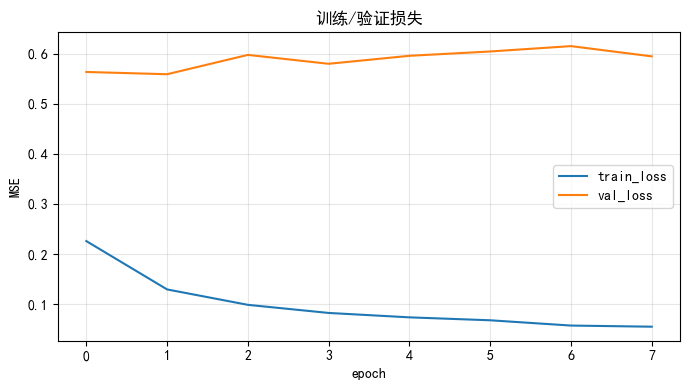

In [17]:
fig = plt.figure(figsize=(7, 4))
plt.plot(history['train_loss'], label='train_loss')
if len(history.get('val_loss', [])) > 0:
    plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.title('训练/验证损失')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

save_figure(fig, run_dir / 'figures' / 'loss_curve.png')

## 7. 预测可视化

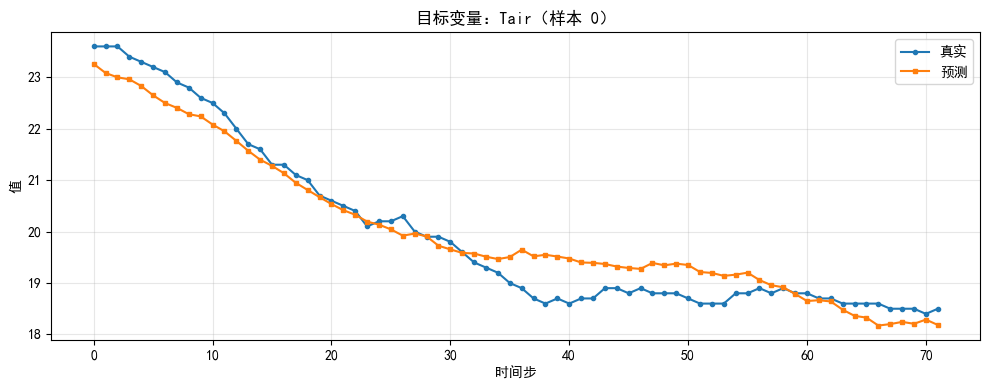

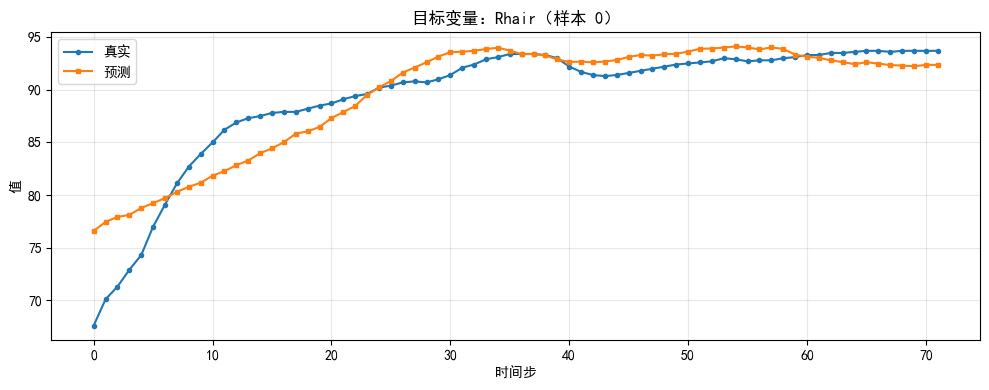

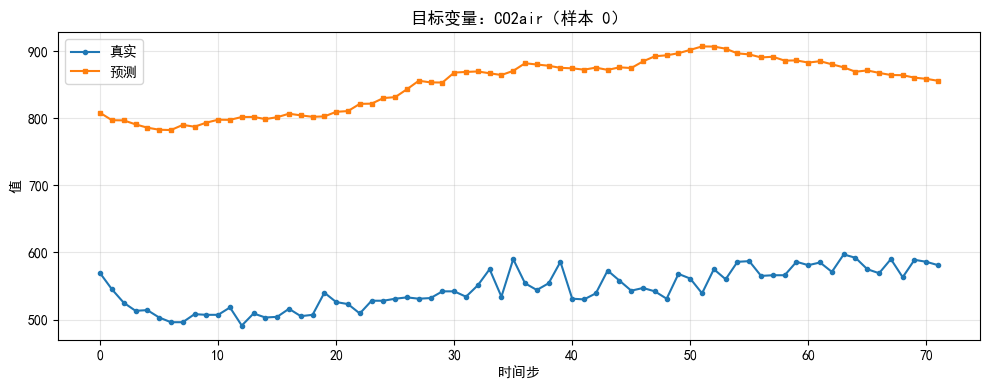

In [18]:
# 单样本预测
model.eval()
x, y = next(iter(test_loader))
x = x.to(device)
with torch.no_grad():
    y_hat = model(x).cpu().numpy()
y_true = y.numpy()

y_hat_inv = target_scaler.inverse_transform(
    y_hat.reshape(-1, len(target_cols))
).reshape(y_hat.shape)
y_true_inv = target_scaler.inverse_transform(
    y_true.reshape(-1, len(target_cols))
).reshape(y_true.shape)

# 为每个目标变量绘图
sample = 0
for var_idx, var_name in enumerate(target_cols):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(y_true_inv[sample, :, var_idx], label='真实', marker='o', markersize=3)
    plt.plot(y_hat_inv[sample, :, var_idx], label='预测', marker='s', markersize=3)
    plt.title(f'目标变量：{var_name}（样本 {sample}）')
    plt.xlabel('时间步')
    plt.ylabel('值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    save_figure(fig, run_dir / 'figures' / f'pred_curve_{var_name}.png')

## 8. 总结

实验完成！查看 `results/` 目录获取详细结果。